# Finding Centroids
This notebook is a follow up of the notebook ilastik/pixels_classification_multiple_channels
We segment our images using the probability images obtained by ilastik and find the centroids of our objects.

## Goal of the analysis
We have a number of images from a confocal microscope containing 4 channels (DAPI, 488, 561 and 642). 

## Prepare the analysis
First of all, we need to import the libraries that we are going to use

In [1]:
import numpy as np
import toolbox
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from getpass import getpass

And define a number of variables that we are going to use in the analysis

In [2]:
# the ID if the dataset containing th raw images and the probability images
RAW_DATASET_ID = 6205
PROBABILITIES_DATASET_ID = 6206

# The name of the group where the data is stored
GROUP = None  # the group where the data is stored

# the URL and port of our OMERO server
OMERO_SERVER = 'workshop.openmicroscopy.org'
PORT = 4064  # the port to connect to. Default is 4046

### Explore your data
Now we can connect to OMERO, get some information on the dataset that we want to analyze and explore the data.

All the data is arranged in two datasets in the same project. One dataset contains the raw images and the other one 
contains the probability images extracted using Ilastik.

In [3]:
# Create a connection
conn = toolbox.open_connection(username=input('OMERO username:'), password=getpass('OMERO password:'), 
                               group=GROUP, host=OMERO_SERVER, port=PORT, secure=True)
print(f'Connection successful: {conn.isConnected()}')

# Get all the images contained in the raw dataset
raw_dataset = toolbox.get_dataset(connection=conn, dataset_id=RAW_DATASET_ID)
raw_images = toolbox.get_dataset_images(dataset=raw_dataset)
raw_images = list(raw_images)

# ... and in the probabilities dataset
prob_dataset = toolbox.get_dataset(connection=conn, dataset_id=PROBABILITIES_DATASET_ID)
prob_images = toolbox.get_dataset_images(dataset=prob_dataset)
prob_images = list(prob_images)

print('RAW IMAGES')
for image in raw_images[:3]:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')

print('PROBABILITY IMAGES')
for image in prob_images[:12]:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')
    

Connection successful: True
RAW IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position003] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
PROBABILITY IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch1_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch2_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch3_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_

You should see 
- a few of the raw images: 3-D stacks of 4 channels (DAPI, X1, X2 and X3) and
- one probability image per each channel in the raw images : 3-D stacks of 2 channels representing the probability of being Foreground (channel 0) and the probability of being Background (channel 1)

http://workshop.openmicroscopy.org/webclient/

### Exploring the raw values
You may load a part of an image as a **_Numpy ndarray_** (n-dimensional array). 
This is Python's way to work very efficient with numeric matrices, and that is what an image is.

In [4]:
# you may use the 'range' optional parameters to get a specified plane or channel or a range (start_included, stop_not_included)
raw_data = toolbox.get_intensities(raw_images[0], 
                                   z_range=(14, 17),  # requests planes 16 and 17 if you start counting with 1
                                   c_range=0)  # This is the DAPI channel

You may now see the dimensions, ...

In [5]:
# The dimensions are stored in the following order (z, c, t, x, y)
print(raw_data.shape)

(3, 1, 1, 1576, 1576)


... data type and raw values.

In [6]:
print(raw_data.dtype)
print(raw_data[0,           # the first plane 15. Note again the 0 based indexing.
               0,           
               0,           # time point 0
               1100:1120,   # x pixels in the format from:until_but_excluded
               90:100]      # for example from pixel 90 until pixel 100 (the pixel at position 100 is excluded)
      )

uint16
[[647 295 606 343 371 495  67 486 970 413]
 [ 87 511 382 677 505 456 180 346 330 364]
 [359 523 423 435  88  72  82 221   2 125]
 [222 140  68 321   0 196 153 295  48  79]
 [455 256 246   1  23 145   3  54 276 372]
 [157  23 174 186  54 417  47  18 100   4]
 [378 308 151 256   2 219   0   3  69 157]
 [ 56 210 247 140  39   3   3   4  97   2]
 [300   2   2  82 106 115 174  26   3   2]
 [ 31   1  36   5   1   3  75   3   3   3]
 [ 31  82  39   2  73  44 126 116 104   3]
 [  4 198   4   7 100   2   3   3   3   3]
 [106  31   4   1  18 238   2   3   4  61]
 [ 16 135   4  26  45   3   2   3   4   2]
 [  4   1 104   3  39   3   3   3 107   3]
 [  4  47   2   2   2   8 134   3   4   2]
 [ 27   1   4  69   4   6   2   2  26   1]
 [  2   4   4   8   3  15   4   3   4   3]
 [ 43  15  45  28  52   4   2   3   2   1]
 [ 37  76   5 101   4   1   5  52   3   4]]


### Visualizing Numpy arrays
You may have a more convenient visualization of these data by using any of the python plotting libraries.
Python's standard library includes matplotlib. We imported previously *matplotlib.pyplot* as *plt* so let's use it.

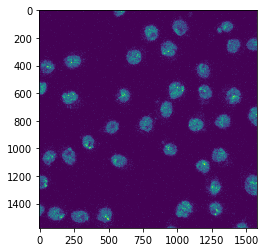

In [7]:
# We create a plot of the image, a Max Intensity Projection for example
MIP = raw_data.max(axis=0)  # specify the axis you want to use for the projection (c=0)
plt.imshow(MIP.squeeze())  # Squeeze is removing all dimensions with size 1, they are not very useful

# Creating the plot just creates it but you always have to show it
plt.show()

matplotlib may create very complex publication-ready plots. You may have a look at what you may do in [here](https://matplotlib.org/gallery.html).

## Running the analysis
Before moving further we have to arrange the images in the two lists so that every raw image has 4 probability images, one per channel.

In [8]:
# We are going to create a list of secondary lists where every secondary list 
# contains the probability images for one single raw image
rearranged_prob_images = list()
for raw_image in raw_images:  # We are looping through every raw image
    name = raw_image.getName()
    # We have to remove all the extra characters introduced by Leica. 
    # Not necessary in principle but as we did it for the probabilities we have to do it again
    name = name.replace('/', '_')
    name = name.replace('.lif [', '_')
    name = name.replace(']', '')
    
    rearranged_prob_images.append(list())  # We append an empty secondary list
    for subfix in ['DAPI_Probabilities',
                   'DAPI_Ch1_Probabilities',
                   'DAPI_Ch2_Probabilities',
                   'DAPI_Ch3_Probabilities']:
        for prob_image in prob_images:
            if name in prob_image.getname() and subfix in prob_image.getname():
                rearranged_prob_images[-1].append(prob_image)
                
# We don't need to keep two lists of probability images
# so we just replace the old list with the new one
prob_images = rearranged_prob_images

Always good to double check...

In [9]:
for i in range(5):
    print(raw_images[i].getName())
    for p in prob_images[i]: print(p.getName())

20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001]
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch1_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch2_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch3_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002]
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Ch1_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Ch2_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position0

## Analyzing the images
Now we have everything ready to start our image analysis. We want to:
- Segment each channel using the probability values extracted by Ilastik in stead of the raw values.
- Save that segmentation into OMERO.
- While we still have the images in memory, we would like to calculate the centroids of the spots this time 
using the raw pixel values.
- We will save the centroid coordinates as a table associated to every image.

For most of the image analysis we are going to use scikit-image, a python iamge analysis library built on top of numpy.
We will have to fix, for each chanel:
 - an upper threshold marking what is going to be defined as an object
 - a lower threshold marking until what probability the object is going to segment
 TODO: put an image

### Creating an analysis function for every image
It's good practice to create a function where you encapsulate the logic of the analysis. Like that it is easier to focus on the work flow.

In [18]:
def run_analysis_image(raw_image, prob_image_list, up_thresholds, low_thresholds, size_thresholds, min_distance):
    """This function encapsulates our analysis of a single OMERO image"""
    
    # We get the pixel size from OMERO
    pixel_size = toolbox.get_pixel_sizes(raw_image)
    
    # We create an empty lists to store the different measurements of the spots
    spots_props = list()
    
    # We now loop through every channel but the DAPI
    for ch_nr, ch_prob in enumerate(prob_image_list[1:]):  # Note the notation [1:]. It means from the second element to the end
        
        print(f'Loading probabilities channel {ch_nr}')        
        # We only want to segment on the probability of being foreground
        ch_prob_data = toolbox.get_intensities(ch_prob, c_range=0)
        
        print('Segmenting...')
        ch_prob_data = ch_prob_data.astype('float16', casting='same_kind')
        labels = toolbox.segment_channel(channel=ch_prob_data.squeeze(),
                                         min_distance=1,
                                         sigma=None,
                                         method='hysteresis',
                                         hysteresis_levels=(low_thresholds[ch_nr], up_thresholds[ch_nr]))
        del(ch_prob_data)                    
        
        # The labels object contains now the segmentation masks for every found object
        # We use it to calculate the properties of every object using the raw data:

        # We get the raw intensity values from OMERO avoiding the DAPI channel
        print(f'Loading raw channel {ch_nr}')        
        raw_data = toolbox.get_intensities(raw_image, c_range=(1 + ch_nr))
                
        print('Computing properties...')
        spots_props_channel = toolbox.compute_channel_spots_properties(channel=raw_data.squeeze(),
                                                                       label_channel=labels)
        del(raw_data)
        
        # We can filter out the spots that are too small
        for i in reversed(range(len(spots_props_channel))):
            if spots_props_channel[i]['area'] < size_thresholds[ch_nr]:
                del spots_props_channel[i]
        
        # We append the spots properties and positions to the lists containing the image measurements
        spots_props.append(spots_props_channel)
        
    # We have all the information collected for every channel we can now apply a function to measure the pairwise distances between the spots
    spots_pos = list()
    for p in spots_props:
        spots_pos.append(np.array([x['weighted_centroid'] for x in p]))
    print('Computing distances...')
    pairwise_distances = toolbox.compute_distances_matrix(positions=spots_pos,
                                                          sigma=min_distance,  # this marks a threshold for the distances that are going to be accepted
                                                          pixel_size=pixel_size,
                                                          remove_mcn=True)
    return pairwise_distances
        

### Running the analysis
Now we have created a function we can apply it to every image in the dataset and collect the results.

Note that this analysis might be more or less slow depending on:
- the speed of the connection between the OMERO and Jupyter servers and
- the CPU specs associated to the Jupyter python kernel.

However, this is not how you are going to analyze large amounts of data. Typically, you are going to deploy the execution of the most demanding tasks to either:
- different execution threads (for example, one thread reading the data from OMERO and another thread doing the calculations)
- different CPU processes (for heavier calculations)
- a HPC cluster (for even heavier calculations)
- or to the GPU (for heavy calculations that can take advantage of these, for example when implementing deep learning)

In [20]:
# Let's fix the probability hysteresis thresholds at which we want to segment.
# There will be an upper threshold and a lower threshold per channel.
upper_thresholds = (.9, .9, .9)
lower_thresholds = (.6, .6, .6)

# We are going to use a size filter to remove the objects that are too small
size_thresholds = (500, 500, 500)

# We should define a minimum distance threshold, in the same units as the data
min_distance = 100

# A list to contain all of the distances
pairwise_distances_dataset = list()

# We create here a small widget to follow the progress
progress = widgets.IntProgress(value=0, min=0, max=len(raw_images), description='Progress:')
display(progress)

# We loop through every image in the raw images list
for index, raw_image in enumerate(raw_images):
    
    print(f'Analyzing image {index} / {len(raw_images)}')
    
    # We run the analysis on every image
    calculated_distances = run_analysis_image(raw_image=raw_image,
                                              prob_image_list=prob_images[index],
                                              up_thresholds=upper_thresholds,   # Do not confuse the name of the function parameters
                                              low_thresholds=lower_thresholds,  # with the name of the variables we are passing
                                              size_thresholds=size_thresholds,
                                              min_distance=min_distance)
    
    pairwise_distances_dataset.append(calculated_distances)
        
    # Update the progress bar
    progress.value = 1 + index

IntProgress(value=0, description='Progress:', max=12)

Analyzing image 0 / 12
Analyzing channel 0
Analyzing channel 1
Analyzing channel 2
Analyzing image 1 / 12
Analyzing channel 0
Analyzing channel 1
Analyzing channel 2


Now we have a rather complex list of lists of dictionaries containing all the relevant data. 
For every combination of channels a and b we know:
- the id of the spot in channel a
- the 3D coordinates of the centroid of that spot (z, x and y)
- the 3D distance to the closest spot in channel b
- the id of the closest spot in channel b

Here is how the data is arranged:
- list: [image0, image1, image2...]
    - list: [ch_1 vs ch_2, ch_1 vs ch_2, ch_2 vs ch_1,...]
        - dictionary: {channels, coord_A, dist_3d, index_A, index_B}

We can request some of these data. For example for image 1 and channels 2 and 3

In [21]:
image_nr = 0
channels = (1, 2)

print('A_ID\tB_ID\tA_xyz_coord\t\t\tAB_distance_3D')
for distances in pairwise_distances_dataset[image_nr]:
    if distances['channels'] == channels:
        for coord_A, dist_3d, index_A, index_B in zip(distances['coord_A'], 
                                                      distances['dist_3d'], 
                                                      distances['index_A'], 
                                                      distances['index_B']):
            print(f'{index_A}\t{index_B}\t{coord_A[1]:.4f}, {coord_A[2]:.4f}, {coord_A[0]:.4f}\t{dist_3d}')
        break

A_ID	B_ID	A_xyz_coord			AB_distance_3D
0	0	672.3885, 318.8346, 9.8843	2.678545478975344
3	2	1351.0084, 838.2805, 10.0452	2.333146580949384
5	1	1275.1111, 1035.6886, 11.2874	0.47455287710822097
7	5	1048.8317, 1488.5022, 14.4034	3.357027972794053
9	6	286.8638, 349.0403, 15.4400	4.407357048908081
11	4	271.9678, 1528.2004, 15.7417	2.2947236395385073
12	10	992.6097, 266.3319, 17.8664	1.2422967241237495
13	11	1404.8133, 583.4668, 19.5149	0.9040115853021758
15	8	1491.2473, 1548.9191, 18.3673	1.9634735780637687
17	13	610.7759, 615.7992, 19.5994	0.3927398277302161
18	12	1205.6865, 635.0886, 18.7400	3.2479710770346326
20	9	1524.9158, 237.3919, 21.6616	70.25533676392406


## Storing the data back into OMERO
We have all the data now, and we can store them back into OMERO

### Storing the spots as ROIs
We can, for example save every spot as a point ROI associated to the image

In [23]:
for distances, raw_image in zip(pairwise_distances_dataset, raw_images):
    
    # We loop over every distance pair, create a 'point shape' and add it to the list
    for distance_pair in distances:

        # We create an empty list to put all the points
        point_shapes = list()

        for (z, x, y), id_a in zip(distance_pair['coord_A'], distance_pair['index_A']):
            point = toolbox.create_shape_point(x_pos=x, 
                                               y_pos=y, 
                                               z_pos=int(z) - 1,  # z position must be entered as an integer
                                               t_pos=0,
                                               point_name=f'Ch:{1 + distance_pair["channels"][0]}_id:{id_a}')
            point_shapes.append(point)

        # We create a ROI containing all of these points. Alternatively, we could create a ROI per point.
        roi = toolbox.create_roi(connection=conn,
                                 image=raw_image,
                                 shapes=point_shapes)

### Storing data as a table
You may store large amounts of data in *_OMERO.tables_*. Let's store the distances as a table.

First we have to extract the data properly. We will need:
- A list with the column names
- A list with the column descriptions (optional).
- A list of columns where every column is a list with the values

We will store:
- Channel (a) where the spot is located
- Channel (b) where the closest spot is located
- Coordinates of the spot
- Units of the coordinates
- 3D-distance to the closest spot
- Units of the Distance

In [40]:
# We create the list with the column names
col_names = ['image_id',
             'channel_a', 
             'channel_b', 
             'coord_z',
             'coord_x',
             'coord_y',
             'coord_units',  # Measurement make no sense without the units
             'mcn_dist_3d',
             'mcn_dist_3d_units',
             ]

# We create the list with the column names
col_desc = ['ID of the image',
            'Channel where the spot is located', 
            'Channel where the mutual closest neighbour spot is located', 
            'Z position of the weighted centroid of the spot',
            'X position of the weighted centroid of the spot',
            'Y position of the weighted centroid of the spot',
            'Position units',
            '3D distance to the mutual closes neighbour (MCN)',
            '3D MCN distance units',
            ]

# We create a list of lists to hold the data
col_data = [list() for e in col_names]

# Let's loop through distances and images to populate the data in th column
for raw_image, distances in zip(raw_images, pairwise_distances_dataset):
    for distance_pair in distances:
        for i in range(len(distance_pair['dist_3d'])):
            col_data[0].append(raw_image.getId())
            col_data[1].append(1 + distance_pair['channels'][0])
            col_data[2].append(1 + distance_pair['channels'][1])
            col_data[3].append(distance_pair['coord_A'][i][0])
            col_data[4].append(distance_pair['coord_A'][i][1])
            col_data[5].append(distance_pair['coord_A'][i][2])
            col_data[6].append('PIXEL')
            col_data[7].append(distance_pair['dist_3d'][i])
            # Note that OMERO provides the pixel size units for each axis. We assume here that the unit is the same for each axis
            col_data[8].append(toolbox.get_pixel_units(raw_image)[0])

Now we are ready to save this table to OMERO and link it to the original dataset

In [39]:
OMERO_table = toolbox.create_annotation_table(connection=conn,
                                              table_name='Distances_table_V1', 
                                              column_names=col_names, 
                                              column_descriptions=col_desc, 
                                              values=col_data)

toolbox.link_annotation(raw_dataset, OMERO_table)

## Closing the connection
Let's clean up after our selves

In [16]:
# Closing the connection to OMERO
conn.close()

# And verifying tha it closed
print(f'Connected? {conn.isConnected()}')


Connected? False
